### Configuración Inicial

En esta sección, se importan las librerías necesarias para el análisis:

- `pandas`: Para la manipulación y el análisis de datos.
- `mlxtend`: Para el algoritmo Apriori y la generación de reglas de asociación, lo cual es útil en el análisis de la canasta de productos.
- `matplotlib.pyplot` y `seaborn`: Para la visualización de datos, incluyendo gráficos de barras, mapas de calor, y otros elementos visuales necesarios en el análisis exploratorio de datos.
- `numpy`: Para realizar operaciones matemáticas y de álgebra lineal.
- `sklearn.tree`: Para construir y visualizar modelos de árbol de decisión, que serán utilizados para realizar predicciones de ventas.
- `sklearn.model_selection`: Para dividir el dataset en conjuntos de entrenamiento y prueba, lo cual ayuda a evaluar la precisión del modelo y prevenir el sobreajuste.

In [1]:
# Ver la salida de varias líneas de una misma celda sin tener que usar la función `print()` en cada línea.
%config InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend.frequent_patterns
import mlxtend.preprocessing
import numpy

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

## Segmentación de clientes

## Canasta de mercado
Se busca con esta herramientas encontrar aquellos productos que se venden juntos en los distintos locales

### Carga de Datos

Se carga el dataset `coffee-shop-sales-revenue.csv` y se convierte la fecha y hora de cada transacción en una sola columna `datetime` para facilitar el análisis temporal.

In [3]:
data = pd.read_csv("./dataset/coffee-shop-sales-revenue.csv", delimiter='|')
data['datetime'] = pd.to_datetime(data['transaction_date'] + ' ' + data['transaction_time'])
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,datetime
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2023-01-01 07:14:04
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2023-01-01 07:20:24
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:22:41


### Extracción de Ubicaciones Únicas

Se obtienen las ubicaciones de los locales del dataset eliminando duplicados en la columna `store_location`. Esto permite segmentar las transacciones por cada local, facilitando el análisis de las asociaciones de productos en cada tienda.

In [4]:
# Obtengo las ubicaciones de los locales
locales = data.drop_duplicates(subset=['store_location'])['store_location']
print(locales)

0      Lower Manhattan
17      Hell's Kitchen
105            Astoria
Name: store_location, dtype: object


### Filtrado de Transacciones por Local

En esta sección, se filtran las transacciones por cada local. Esto se hace creando una lista `datos_por_local`, que contiene las transacciones de cada tienda, segmentadas por fecha, hora y tipo de producto. Este paso es fundamental para analizar las ventas de cada tienda por separado.

In [5]:
# Extraigo las transacciones por locales
datos_por_local = []
for local in locales:
    ventas = data[data['store_location'] == local][['datetime', 'product_type']]
    datos_por_local.append(ventas)

### Extracción de Tipos de Productos Vendidos por Local

Aquí se extraen los tipos de productos vendidos en cada tienda, eliminando duplicados en la columna `product_type`. Esto permite construir una lista de productos únicos por tienda y facilita la creación de una matriz de "one-hot encoding" para el análisis de la canasta de productos.

In [6]:
# Extraigo los tipos de productos que se vendieron en cada local
tmpVentas = []
productos = []
for x in range(len(datos_por_local)):
    tmpVentas.append(datos_por_local[x])
    productos.append(pd.DataFrame(datos_por_local[0]).drop_duplicates('product_type')['product_type'].tolist())    
    productos[x].insert(0, 'datetime')

### Conversión de Productos en Columnas (One-Hot Encoding)

En este paso, se crean matrices donde cada columna representa un tipo de producto y cada fila representa una transacción en una fecha y hora específica. El valor 1 indica que el producto fue comprado en esa transacción y 0 indica que no lo fue. Este formato es necesario para aplicar el algoritmo Apriori.

In [7]:
# Convierto los productos en columnas
MBA_data = []
for x in range(len(productos)):
    MBA_data.append(pd.DataFrame([productos[x]]))
    MBA_data[x].columns = productos[x]

### Construcción de la Matriz de Productos Comprados por Fecha

Se crea una matriz por cada tienda donde cada fila representa una fecha y hora específica, y cada columna indica si un producto fue comprado en esa transacción. Este paso transforma los datos en un formato adecuado para el análisis de la canasta de productos.

In [8]:
# NO EJECUTAR A MENOS QUE SEA NECESARIO
# Construyo la matriz en base a productos comprados por fecha

# Crear una matriz de "one-hot encoding" usando pivot y fillna para evitar el bucle
for x in range(len(tmpVentas)):
    # Crear una columna 'comprado' con valor 1 para indicar que se compró el producto en esa transacción
    tmpVentas[x]['comprado'] = 1

    # Convertir los datos al formato de "one-hot encoding" usando pivot
    MBA_data[x] = tmpVentas[x].pivot_table(
        index='datetime',
        columns='product_type',
        values='comprado',
        fill_value=0
    ).reset_index()

# Ahora MBA_data[x] debería tener un formato de "one-hot encoding" con menos costo computacional

### Agrupación de Transacciones por Fecha

Aquí se agrupan las transacciones que tienen la misma fecha y hora para consolidar las compras simultáneas. Luego, se convierten los valores en booleanos (True/False) para indicar si el producto fue o no comprado en una transacción específica. Esto facilita el análisis de asociación.

In [9]:
# Agrupamos las columnas que tienen la misma fecha
MBA_data_grp = []
for x in range(len(MBA_data)):
    MBA_data_grp.append(MBA_data[x].groupby('datetime').sum().reset_index())
    MBA_data_grp[x] = MBA_data_grp[x].drop(columns=['datetime'])
    MBA_data_grp[x] = MBA_data_grp[x].map(lambda x: True if x >= 1 else False)

### Análisis de la Canasta de Productos

Se aplica el algoritmo Apriori a cada tienda con un soporte mínimo de 0.001, lo cual permite identificar conjuntos de productos que se compran juntos frecuentemente. Luego, se generan reglas de asociación usando `lift` como métrica principal. El `lift` mide la relación entre la frecuencia observada de los productos y la esperada, indicando la fuerza de la asociación.

In [10]:
# Realizamos el análisis
frequent_itemsets = []
rules = []
for x in range(len(MBA_data_grp)):
    frequent_itemsets.append(apriori(MBA_data_grp[x], min_support=0.001, use_colnames=True))
    rules.append(association_rules(frequent_itemsets[x], metric="lift"))
    #rules.sort_values(['support', 'confidence', 'lift'], axis = 0, ascending = False).head(10)

### Visualización de Resultados

Se muestran las reglas de asociación obtenidas para cada tienda, ordenadas por soporte, confianza y `lift`. Este análisis ayuda a identificar patrones de compra en cada tienda y puede ser útil para desarrollar estrategias de venta cruzada o promociones específicas.

In [11]:
# Mostramos los valores obtenidos
for x in range(len(rules)):
    print("--------------------------------------------------------------------------------------------------------------------------------------------")
    print(f"Localidad: {locales.iloc[x]}")
    rules[x].sort_values(['support', 'confidence', 'lift'], axis = 0, ascending = False).head(10)

--------------------------------------------------------------------------------------------------------------------------------------------
Localidad: Lower Manhattan


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,(Regular syrup),(Barista Espresso),0.058706,0.148631,0.058622,0.998567,6.718418,0.049897,593.971624,0.904240
7,(Barista Espresso),(Regular syrup),0.148631,0.058706,0.058622,0.394414,6.718418,0.049897,1.554352,0.999749
10,(Sugar free syrup),(Barista Espresso),0.023253,0.148631,0.023253,1.000000,6.728062,0.019796,inf,0.871637
11,(Barista Espresso),(Sugar free syrup),0.148631,0.023253,0.023253,0.156445,6.728062,0.019796,1.157894,1.000000
8,(Scone),(Barista Espresso),0.097330,0.148631,0.021570,0.221614,1.491032,0.007103,1.093761,0.364832
9,(Barista Espresso),(Scone),0.148631,0.097330,0.021570,0.145122,1.491032,0.007103,1.055905,0.386816
40,(Scone),(Brewed Chai tea),0.097330,0.142040,0.013267,0.136311,0.959670,-0.000558,0.993367,-0.044485
41,(Brewed Chai tea),(Scone),0.142040,0.097330,0.013267,0.093404,0.959670,-0.000558,0.995670,-0.046695
57,(Scone),(Gourmet brewed coffee),0.097330,0.146331,0.012285,0.126225,0.862597,-0.001957,0.976989,-0.149997
56,(Gourmet brewed coffee),(Scone),0.146331,0.097330,0.012285,0.083956,0.862597,-0.001957,0.985401,-0.157253


--------------------------------------------------------------------------------------------------------------------------------------------
Localidad: Hell's Kitchen


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(Regular syrup),(Barista Espresso),0.043704,0.151456,0.043407,0.993213,6.557765,0.036788,125.018820,0.886241
5,(Barista Espresso),(Regular syrup),0.151456,0.043704,0.043407,0.286600,6.557765,0.036788,1.340477,0.998780
6,(Scone),(Barista Espresso),0.084590,0.151456,0.019207,0.227060,1.499183,0.006395,1.097814,0.363739
7,(Barista Espresso),(Scone),0.151456,0.084590,0.019207,0.126816,1.499183,0.006395,1.048358,0.392402
8,(Sugar free syrup),(Barista Espresso),0.014881,0.151456,0.014881,1.000000,6.602579,0.012627,inf,0.861362
9,(Barista Espresso),(Sugar free syrup),0.151456,0.014881,0.014881,0.098254,6.602579,0.012627,1.092457,1.000000
41,(Scone),(Gourmet brewed coffee),0.084590,0.139294,0.010283,0.121566,0.872732,-0.001500,0.979819,-0.137412
40,(Gourmet brewed coffee),(Scone),0.139294,0.084590,0.010283,0.073824,0.872732,-0.001500,0.988376,-0.144881
37,(Scone),(Brewed herbal tea),0.084590,0.091511,0.006773,0.080070,0.874975,-0.000968,0.987563,-0.135018
36,(Brewed herbal tea),(Scone),0.091511,0.084590,0.006773,0.074014,0.874975,-0.000968,0.988579,-0.135907


--------------------------------------------------------------------------------------------------------------------------------------------
Localidad: Astoria


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
4,(Regular syrup),(Barista Espresso),0.027259,0.119531,0.027013,0.990983,8.290592,0.023755,97.644010,0.904024
5,(Barista Espresso),(Regular syrup),0.119531,0.027259,0.027013,0.225992,8.290592,0.023755,1.256759,0.998765
34,(Scone),(Brewed Chai tea),0.078483,0.153893,0.012290,0.156593,1.017539,0.000212,1.003200,0.018705
35,(Brewed Chai tea),(Scone),0.153893,0.078483,0.012290,0.079859,1.017539,0.000212,1.001496,0.020372
49,(Scone),(Gourmet brewed coffee),0.078483,0.148658,0.010840,0.138115,0.929077,-0.000827,0.987767,-0.076502
48,(Gourmet brewed coffee),(Scone),0.148658,0.078483,0.010840,0.072917,0.929077,-0.000827,0.993996,-0.082289
8,(Sugar free syrup),(Barista Espresso),0.009316,0.119531,0.009045,0.970976,8.123216,0.007932,30.336159,0.885142
9,(Barista Espresso),(Sugar free syrup),0.119531,0.009316,0.009045,0.075673,8.123216,0.007932,1.071790,0.995942
52,(Scone),(Hot chocolate),0.078483,0.105447,0.009021,0.114939,1.090018,0.000745,1.010725,0.089617
53,(Hot chocolate),(Scone),0.105447,0.078483,0.009021,0.085548,1.090018,0.000745,1.007726,0.092318


## Arbol de decisión

### Carga de Datos y Exploración Inicial

Se importan las librerías necesarias: `pandas` para manejar los datos, `DecisionTreeRegressor` de `sklearn` para construir el modelo de árbol de decisión, `matplotlib` para visualización y `train_test_split` para dividir los datos en conjuntos de entrenamiento y prueba. Luego, se carga el archivo CSV `coffee-shop-sales-revenue_modified.csv`, utilizando el delimitador `;` para separar las columnas. Finalmente, se visualizan las primeras filas del dataset para confirmar que los datos se cargaron correctamente.

In [12]:
# Cargar el dataset con el delimitador correcto
ruta_dataset = "./dataset/coffee-shop-sales-revenue.csv"
ventas_producto = pd.read_csv(ruta_dataset, delimiter='|')

In [13]:
# Ver las primeras filas del dataset para confirmar que cargó correctamente
display(ventas_producto.head())

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


### Extracción de Mes y Año de las Transacciones

Para facilitar el análisis, se extraen los valores de mes y año de la columna `transaction_date` y se añaden como nuevas columnas `Mes` y `Año` en el dataset. Este paso permite desglosar las ventas por mes y año, facilitando el análisis temporal y la preparación de datos para el modelo de árbol de decisión.

In [14]:
# Extraer el mes y el año de la columna 'transaction_date'
ventas_producto['transaction_date'] = pd.to_datetime(ventas_producto['transaction_date'])
ventas_producto['Mes'] = ventas_producto['transaction_date'].dt.month
ventas_producto['Año'] = ventas_producto['transaction_date'].dt.year

In [15]:
# Verificar que se añadieron las nuevas columnas
display(ventas_producto[['transaction_date', 'Mes', 'Año']].head())

,transaction_date,Mes,Año
0,2023-01-01,1,2023
1,2023-01-01,1,2023
2,2023-01-01,1,2023
3,2023-01-01,1,2023
4,2023-01-01,1,2023


### Filtrado de Producto y Categoría de Interés

Se especifican un tipo de producto (`product_type`) y una categoría de producto (`product_category`) de interés. En este caso, se seleccionan `'Scone'` en la categoría `'Bakery'`. Luego, se filtran las ventas de este producto en específico, permitiendo concentrarse únicamente en el comportamiento de ventas del producto seleccionado.

In [16]:
# Especificar el product_type y product_category de interés
producto_interes = 'Scone'  # Cambiar al producto que te interese
categoria_interes = 'Bakery'  # Cambiar a la categoría de interés

In [17]:
# Filtrar las ventas de este producto y categoría
ventas_filtradas = ventas_producto[(ventas_producto['product_type'] == producto_interes) &
                                   (ventas_producto['product_category'] == categoria_interes)]

### Resumen de Ventas por Mes para el Producto

Se agrupan las ventas por mes para el producto seleccionado (`'Scone'` en la categoría `'Bakery'`) y se resumen las ventas para los primeros 4 meses del año. Esto proporciona una visión clara de las ventas en los primeros meses y sirve como base para realizar predicciones de ventas futuras.

In [18]:
# Resumir las ventas por mes para los primeros 4 meses
ventas_resumidas = ventas_filtradas.groupby('Mes')['transaction_qty'].sum().loc[1:4]
print(f"Ventas de {producto_interes} en los primeros meses:\n{ventas_resumidas}")

Ventas de Scone en los primeros meses:
Mes
1    1234
2    1139
3    1492
4    1822
Name: transaction_qty, dtype: int64


In [19]:
# Mostrar las ventas en los primeros 4 meses
for mes, cantidad in ventas_resumidas.items():
    print(f"En el mes {mes} se vendieron {cantidad} unidades de {producto_interes} ({categoria_interes}).")

En el mes 1 se vendieron 1234 unidades de Scone (Bakery).
En el mes 2 se vendieron 1139 unidades de Scone (Bakery).
En el mes 3 se vendieron 1492 unidades de Scone (Bakery).
En el mes 4 se vendieron 1822 unidades de Scone (Bakery).


### **Distribución de Ventas por Mes para el Producto Seleccionado**
   Gráfico de barras para visualizar la cantidad de ventas del producto seleccionado por mes. Permite observar la variabilidad de las ventas a lo largo del tiempo y es útil para identificar tendencias.

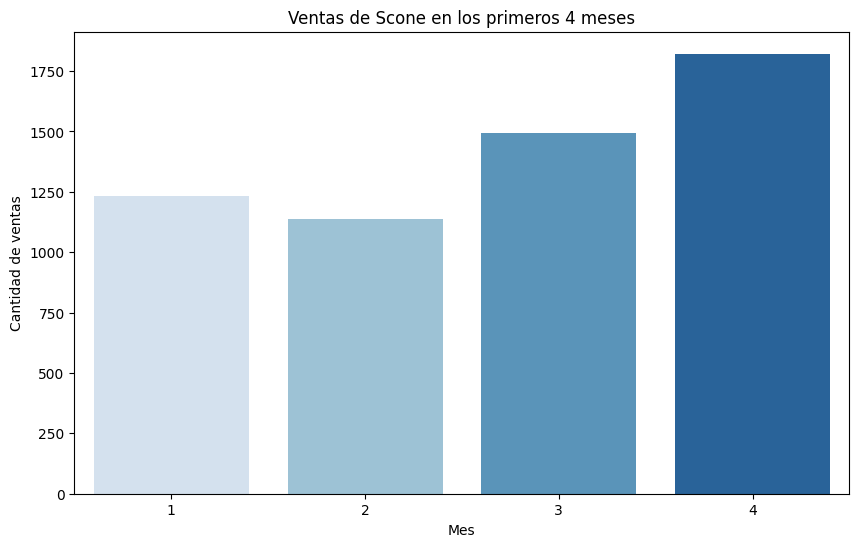

In [20]:
import warnings

# Ignorar advertencias temporales de FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Gráfico de barras para ventas por mes
plt.figure(figsize=(10, 6))
sns.barplot(x=ventas_resumidas.index, y=ventas_resumidas.values, palette="Blues", hue=None)
plt.title(f"Ventas de {producto_interes} en los primeros 4 meses")
plt.xlabel("Mes")
plt.ylabel("Cantidad de ventas")
plt.show();

### **Distribución de Ventas Filtradas por Año y Mes**
   Visualizar la cantidad de ventas de todos los meses (y años si hay varios) para identificar patrones de ventas para el producto de interés. Un gráfico de línea permite observar las tendencias a lo largo del tiempo.

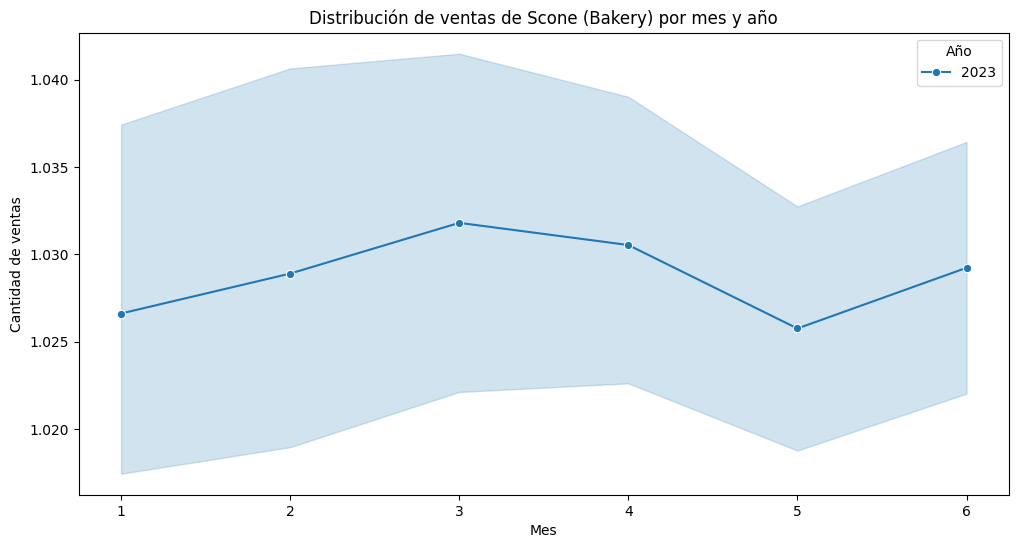

In [21]:
# Gráfico de línea para ventas por mes y año
plt.figure(figsize=(12, 6))
sns.lineplot(data=ventas_filtradas, x="Mes", y="transaction_qty", hue="Año", marker="o", palette="tab10")
plt.title(f"Distribución de ventas de {producto_interes} ({categoria_interes}) por mes y año")
plt.xlabel("Mes")
plt.ylabel("Cantidad de ventas")
plt.legend(title="Año")
plt.show();

### Selección de Características para el Modelo

Se seleccionan las características `Mes` y `Año` como variables predictoras (`X`) y la cantidad de ventas (`transaction_qty`) como variable de salida (`y`) para el modelo de árbol de decisión. Esto permite que el modelo aprenda patrones de ventas mensuales a lo largo del tiempo.

In [22]:
# Seleccionar las características para el modelo de árbol de decisión
X_producto = ventas_filtradas[['Mes', 'Año']]  # Mes y Año
y_producto = ventas_filtradas['transaction_qty']

### División de los Datos en Entrenamiento y Prueba

Los datos se dividen en un conjunto de entrenamiento y uno de prueba, utilizando un 20% de los datos para pruebas. Esta división permite entrenar el modelo en una parte de los datos y luego evaluar su precisión en datos no vistos, ayudando a evitar sobreajuste.

In [23]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_producto, y_producto, test_size=0.2, random_state=42)

### Entrenamiento del Modelo de Árbol de Decisión

Se entrena un modelo de árbol de decisión con una profundidad máxima de 4 niveles y un mínimo de 2 muestras por división. Este modelo aprende los patrones de ventas mensuales y permite realizar predicciones de ventas en meses futuros, basándose en los datos históricos de ventas.

In [24]:
# Entrenar el modelo
modelo_arbol_producto = DecisionTreeRegressor(max_depth=4, min_samples_split=2, random_state=42)
modelo_arbol_producto.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

### Preparación de Meses Futuros para Predicción

Se crea un DataFrame con los meses futuros (del 5 al 8) en el año 2024, que serán usados para realizar predicciones de ventas para los próximos meses. Esto permite estimar cómo podrían evolucionar las ventas del producto `'Scone'` en la categoría `'Bakery'` en el próximo periodo.

In [25]:
# Definir meses futuros para realizar predicciones (meses 5 a 8)
meses_futuros = pd.DataFrame({
    'Mes': [5, 6, 7, 8],  # Meses futuros
    'Año': [2024] * 4  # Años futuros
})

### Realización de Predicciones para los Meses Futuros

Se utiliza el modelo de árbol de decisión entrenado para predecir las ventas de `'Scone'` en los meses 5 a 8 del año 2024. Los resultados se muestran para cada mes, proporcionando una estimación de las ventas futuras del producto seleccionado.

In [26]:
# Realizar predicciones para los meses futuros
ventas_futuras = modelo_arbol_producto.predict(meses_futuros)

In [27]:
# Mostrar las predicciones para los próximos meses
print(f"Predicciones de ventas para {producto_interes} ({categoria_interes}) en los próximos meses de 2024:")
for mes, prediccion in zip(meses_futuros['Mes'], ventas_futuras):
    print(f"Mes {mes}: {prediccion:.2f} unidades")

Predicciones de ventas para Scone (Bakery) en los próximos meses de 2024:
Mes 5: 1.03 unidades
Mes 6: 1.03 unidades
Mes 7: 1.03 unidades
Mes 8: 1.03 unidades


### **Predicciones de Ventas para Meses Futuros**
   Puedes crear un gráfico de barras para comparar las ventas reales de los primeros cuatro meses con las predicciones de los meses futuros. Esto facilita la comparación visual entre datos históricos y predicciones.

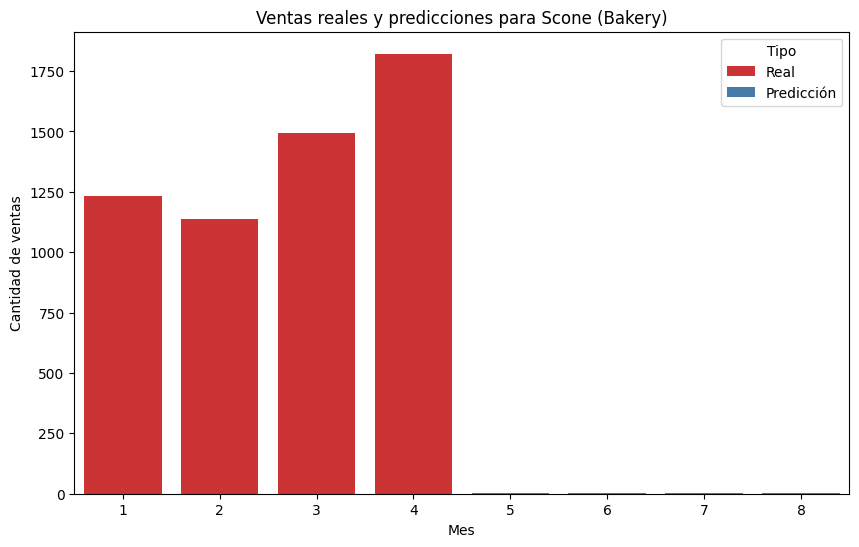

In [28]:
# Crear un DataFrame para combinar ventas reales y predicciones
meses_hist = list(ventas_resumidas.index)
ventas_hist = list(ventas_resumidas.values)
pred_df = pd.DataFrame({
    "Mes": meses_hist + list(meses_futuros['Mes']),
    "Cantidad de ventas": ventas_hist + list(ventas_futuras),
    "Tipo": ["Real"] * len(ventas_hist) + ["Predicción"] * len(ventas_futuras)
})

# Gráfico de barras con ventas reales y predicciones
plt.figure(figsize=(10, 6))
sns.barplot(data=pred_df, x="Mes", y="Cantidad de ventas", hue="Tipo", palette="Set1")
plt.title(f"Ventas reales y predicciones para {producto_interes} ({categoria_interes})")
plt.xlabel("Mes")
plt.ylabel("Cantidad de ventas")
plt.show();

### Visualización del Árbol de Decisión

Se visualiza el árbol de decisión construido, mostrando cómo el modelo toma decisiones basadas en el mes y año de las transacciones. Esta visualización ayuda a entender el proceso de decisión del modelo y a ver los nodos y hojas que representan las divisiones y predicciones finales del árbol.

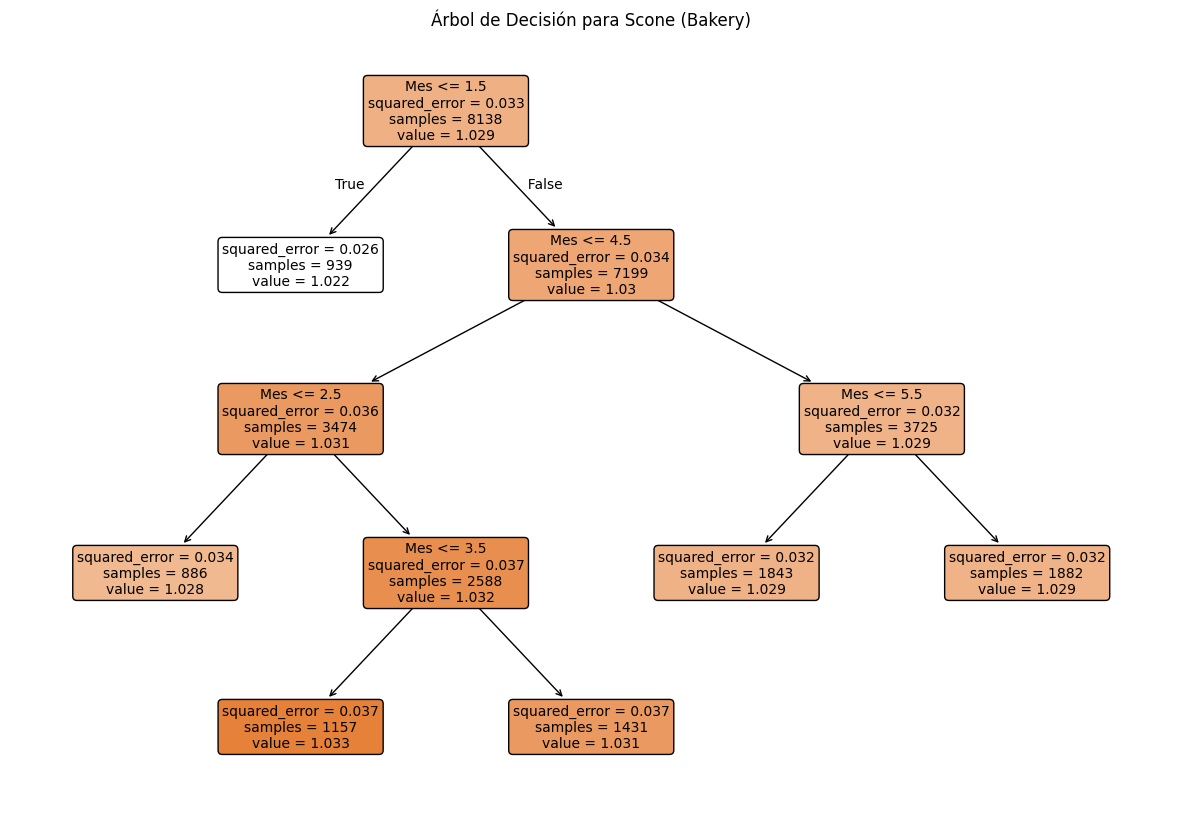

In [29]:
# Visualizar el árbol de decisión
plt.figure(figsize=(15, 10))
plot_tree(modelo_arbol_producto, filled=True, feature_names=['Mes', 'Año'], class_names=True, rounded=True, fontsize=10)
plt.title(f"Árbol de Decisión para {producto_interes} ({categoria_interes})")
plt.show();

### **Correlación de Variables para Exploración Adicional**
   Gráfico de mapa de calor para ver las correlaciones entre todas las variables en el dataset, lo cual puede ayudar a identificar qué variables afectan más las ventas.

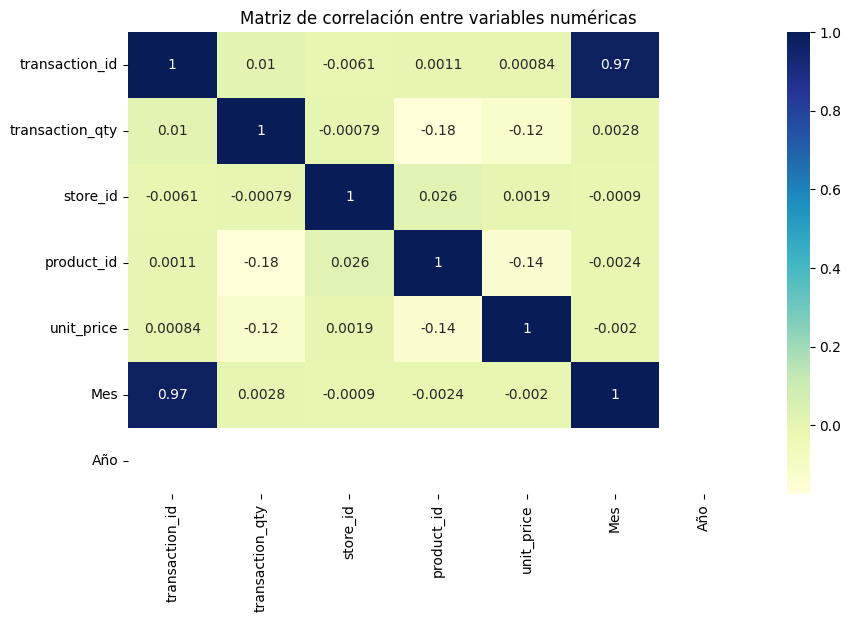

In [30]:
# Filtrar solo columnas numéricas
numeric_cols = ventas_producto.select_dtypes(include=['number'])

# Mapa de calor de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="YlGnBu")
plt.title("Matriz de correlación entre variables numéricas")
plt.show();